Candidato: Murilo Krebsky Hobus

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from google.colab import drive
from scipy.stats import normaltest, shapiro, zscore, pearsonr
import math
#drive.mount('/content/drive')

In [3]:
df = pd.read_csv('psel - data.csv')

In [4]:
df.head(10)

,data,receita,transacoes_blog,transacoes_site,usuarios_blog,usuarios_site
0,2019-01-01,349184,0,4693,0,46739
1,2019-01-02,867328,0,8501,0,83129
2,2019-01-03,758590,0,9375,0,86067
3,2019-01-04,688873,0,8405,0,69363
4,2019-01-05,441760,0,6136,0,56183
5,2019-01-06,539398,0,5762,0,50790
6,2019-01-07,703413,0,8072,0,73742
7,2019-01-08,884104,0,9455,0,84951
8,2019-01-09,911559,0,10152,0,80605
9,2019-01-10,946827,0,11294,0,87958


In [5]:
df.describe()

,receita,transacoes_blog,transacoes_site,usuarios_blog,usuarios_site
count,6.390000e+02,639.000000,639.000000,639.000000,639.000000
mean,1.622682e+06,528.350548,19039.140845,1439.848200,101610.485133
std,1.161892e+06,1201.781347,13677.729723,3369.872063,37240.234152
min,-2.022000e+04,0.000000,3557.000000,0.000000,26298.000000
25%,8.073420e+05,0.000000,11013.000000,0.000000,77727.000000
50%,1.263161e+06,0.000000,16069.000000,0.000000,96104.000000
75%,2.232770e+06,0.000000,22606.500000,0.000000,117586.500000
max,1.226684e+07,5586.000000,188955.000000,13059.000000,369989.000000


Obs: Existem valores negativos na variável receita que precisam ser retirados

In [6]:
df.dtypes

data               object
receita             int64
transacoes_blog     int64
transacoes_site     int64
usuarios_blog       int64
usuarios_site       int64
dtype: object

In [7]:
df['data'] = pd.to_datetime(df['data'], yearfirst=True) #format: YY/MM/DD
df = df[df['receita'] > 0]

## As receitas aumentaram?

A primeira(e mais natural) pergunta que podemos fazer é: a criação do blog tem alguma relação com a receita da empresa?Essa seria a relação mais direta que poderíamos ter. Vamos explorar essa hipótese.

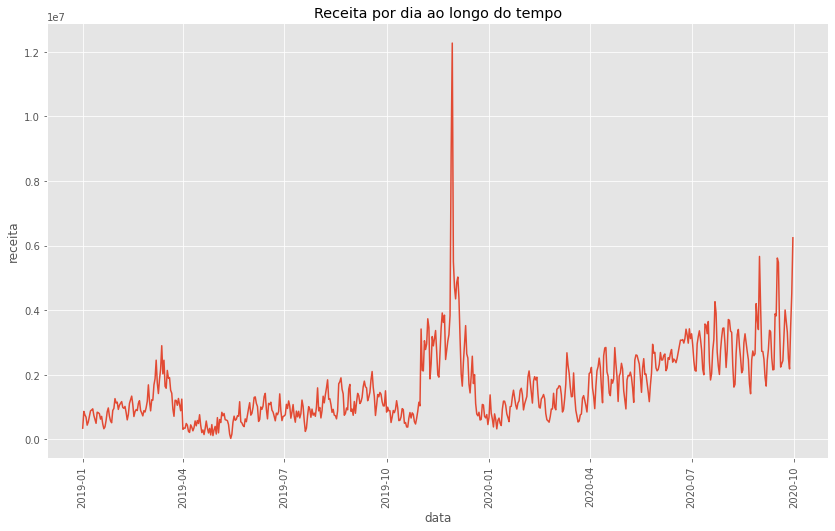

In [11]:
plt.style.use("ggplot")
plt.figure(figsize=(14,8))
plt.xticks(rotation='vertical')
plt.title('Receita por dia ao longo do tempo')
sns.lineplot(x='data', y='receita', data=df)
plt.savefig('receita.jpg')

Primeiramente, olhando a evolução da renda ao longo do tempo alguns fatores chamam a atenção:

* Um grande pico próximo ao final de 2019
* Uma crescente a partir de 2020

In [12]:
print(round(np.max(df['receita']) - np.mean(df['receita'])))

10641587


Podemos ver uma enorme diferença entre a média e esse pico. Poder ser realmente só um outlier ou até mesmo um erro de digitação (o que é mais improvável pois esse mesmo padrão se repete em acessos so site, por exemplo). Vamos descartar esse evento e checar outros possíveis outliers.

In [13]:
Xzscore = zscore(df['receita'])
outliers = np.abs(Xzscore) > 2.8
outliers_id = np.argwhere(outliers == True)
temp = df 
df_wOutliers = temp.drop(outliers_id[:,0],axis=0)
outliers = temp.loc[outliers_id[:,0]]

df_wOutliers = df_wOutliers[df_wOutliers['receita'] > 0]


In [14]:
print('Foram retirados', outliers.shape[0], 'outliers')

Foram retirados 8 outliers


In [15]:
outliers['acimaMedia'] = outliers['receita'].apply(lambda x: x>np.mean(df_wOutliers['receita']))
outliers[['data', 'receita', 'acimaMedia']].sort_values(by='receita', ascending=False)

,data,receita,acimaMedia
332,2019-11-29,12266844,True
331,2019-11-28,8853976,True
624,2020-09-16,5614618,True
336,2019-12-03,4858419,True
637,2020-09-29,4519732,True
330,2019-11-27,3836341,True
623,2020-09-15,3825491,True
607,2020-08-30,3400766,True


Como nenhuma data dos outliers é comemorativa, e também são todas ocorrências com mais vendas do que a média, é razoável de se supor que essas observações podem ser fruto de promoções, por exemplo. Vamos visualizar as receitas ao longo do tempo novamente, mas sem esses outliers agora:

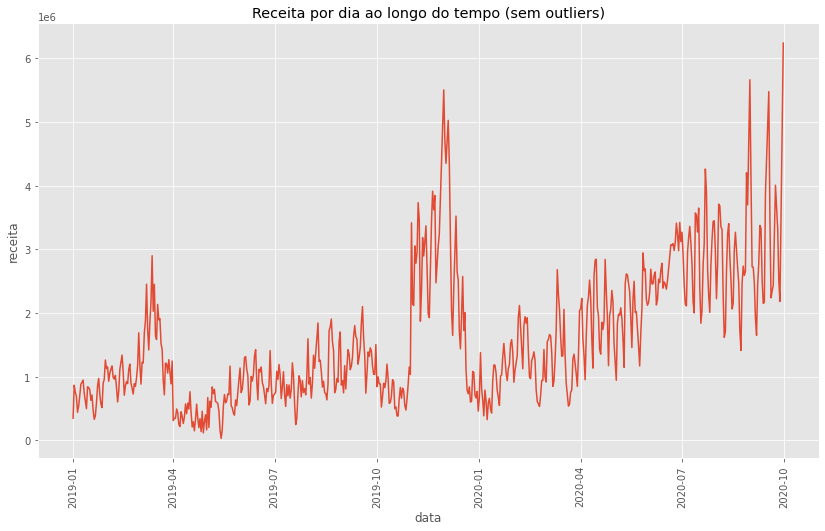

In [16]:
plt.figure(figsize=(14,8))
plt.xticks(rotation='vertical')
plt.title('Receita por dia ao longo do tempo (sem outliers)')
sns.lineplot(x='data', y='receita', data=df_wOutliers)
plt.savefig('receita_wOutlier.jpg')

Sem os outliers fica mais fácil ainda de se observar a crescente de receitas em 2020. Além disso, o blog foi criado no em 07/20, vamos explorar se ele tem algum efeito nessa crescente.

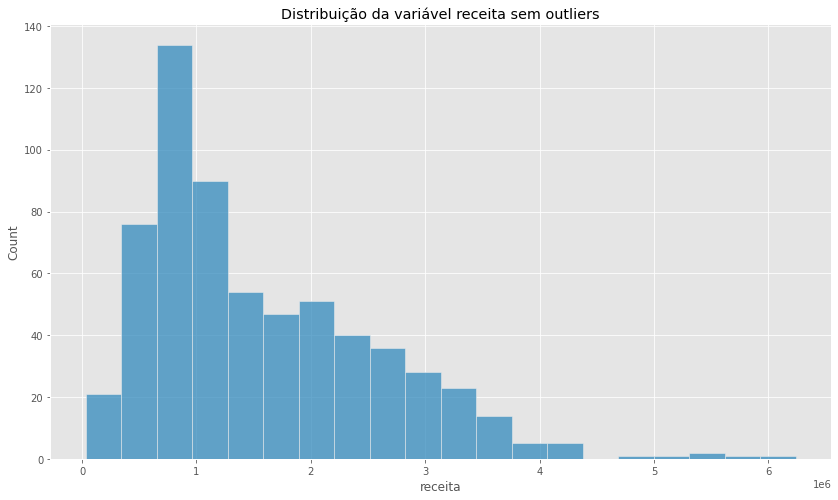

In [17]:
plt.figure(figsize=(14,8))
plt.title('Distribuição da variável receita sem outliers')
sns.histplot(df_wOutliers['receita'])
plt.savefig('dist_receita.jpg')

O que chama atenção é que a receita tem certa semelhança com uma distribuição normal. Portanto, vamos fazer um teste de normalidade para termos um melhor embasamento.

In [18]:
t1, p1 = normaltest(df_wOutliers['receita'])
t2, p2 = shapiro(df_wOutliers['receita'])

print(t1, p1)
print(t2, p2)

104.70909528414529 1.8310864821828053e-23
0.91179358959198 1.161595982330533e-18


### Teste de hipótese

Como podemos ver, os dados falham quando postos à prova por testes de normalidade. Porém isso não é motivo para desespero, pois apesar disso, a estatística de teste que iremos utilizar, converge para uma distribuição t.

(Além disso é bem razoável de se considerar que com mais tempo, veríamos uma distribuição normal. Considerando poucos dias com receitas muito altas ou muito baixas, e que na maioria dos dias a receita fica ao redor de uma certa média)

Assim, fazendo as seguintes suposições:
* $X = X_1, X_2, ..., X_{nX}$, são as receitas antes da criação do blog
* $Y = Y_1, Y_2, ..., X_{nY}$, são as receitas após a criação do blog
* X e Y são amostras aleatórias, ou seja, a receita de cada dia é aleatória e as receitas de dias diferentes são independentes e provenientes de uma mesma distribuição
* X e Y são independentes

Podemos fazer o seguinte teste de hipótese:

$H_0: \mu_D = 0$ vs $H_1: \mu_D < 0$, considerando que as variâncias são diferentes, sendo $\mu_D = \mu_{antes} - \mu_{depois}$ a média das receitas

In [19]:
idx = (df_wOutliers['usuarios_blog'] > 0).idxmax()  #data do evento

X = df_wOutliers.loc[0:idx-1]['receita']  #dados antes do evento
nX = len(X)
X_barra = np.mean(X)
S_X = np.var(X)

Y = df_wOutliers.loc[idx:]['receita']  #dados após o evento
nY = len(Y)
Y_barra = np.mean(Y)
S_Y = np.var(Y)

T_obs = (X_barra - Y_barra)/math.sqrt((S_X/ nX) + (S_Y/nY))
numerador = ((S_X/nX) + (S_Y/nY))**2
denominador = ((((S_X/nX)**2)/(nX-1)) + (((S_Y/nY)**2)/(nY-1)))
gl = numerador/denominador

alpha = 0.01
t_critico = -2.343899 #quantil 

if T_obs <= t_critico:
  print('Hipótese nula rejeitada: a média após o evento é maior')
else: print('Hipótese nula aceita: a média não se alterou')

Hipótese nula rejeitada: a média após o evento é maior


#### Aqui, encontramos a primeira evidência de que a **criação do blog tem uma influência positiva nas receitas da empresa**

## O blog atrai possíveis compradores?

Outra maneira de avaliar a criação do blog, é entender se as pessoas que passam por ele, fazem compras no site. Traduzindo isso para os dados, a pergunta é: existe correlação entre os acessos ao blog e as transacoes que passam pelo blog?

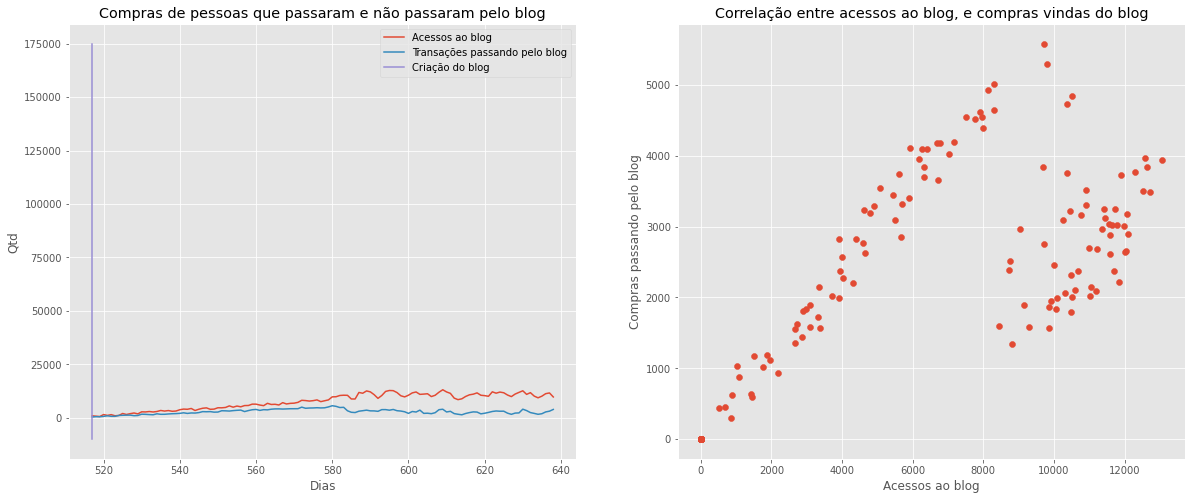

In [20]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,8))

point1 = [517,-10000]
point2 = [517,175000]
x_values = [point1[0], point2[0]]
y_values = [point1[1], point2[1]]

ax1.set(title='Compras de pessoas que passaram e não passaram pelo blog')
ax1.plot(df.loc[idx:]['usuarios_blog'], label='Acessos ao blog')
ax1.plot(df.loc[idx:]['transacoes_blog'], label='Transações passando pelo blog')
ax1.plot(x_values, y_values, label='Criação do blog')
ax1.set(xlabel='Dias')
ax1.set(ylabel='Qtd')
ax1.legend()

ax2.scatter(df['usuarios_blog'], df['transacoes_blog'])
ax2.set(title='Correlação entre acessos ao blog, e compras vindas do blog')
ax2.set(xlabel='Acessos ao blog')
ax2.set(ylabel='Compras passando pelo blog')

plt.savefig('compras_comparacao.jpg')

In [21]:
pearsonr(df['usuarios_blog'], df['transacoes_blog'])[0]

0.8933110610221995

Aparentemente existe um aumento(natural) no número de compras feitas por pessoas que passaram pelo blog a medida que os acessos aumentam, mas que após um certo tempo, esse número estabiliza. De fato, o blog adquire algum público, que passa a acessá-lo regularmente, mas que não necessariamente sempre faz compras.

Observe que a hipótese de que os acessos ao blog são das mesmas pessoas que já compravam no site não é muito provável. Ou seja, provavelmente, a maioria dos acessos ao blog (que posteriormente podem se transformar em compras) são de novos clientes, pois a receita aumentou nesse período. É muito mais plusível considerar que novos clientes estão comprando do que pensar que os clientes antigos estão comprando mais justamente nesse período(após a criação do blog)

Apesar de **correlação não implicar causalidade, aqui temos mais uma evidência de que a influência do blog é positiva**, nesse caso ele está sendo efetivo no que diz respeito a transformar acessos em compras.

# Clientes novos ou antigos estão acessando o blog?


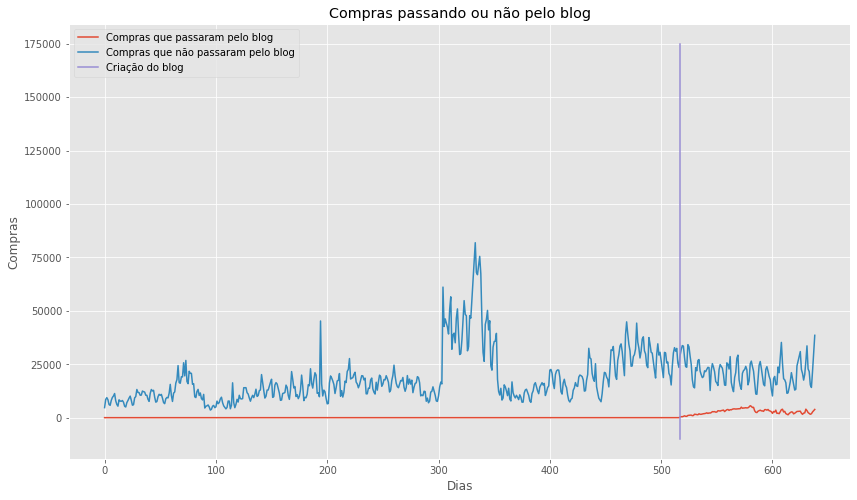

In [22]:
plt.figure(figsize = (14,8))

point1 = [517,-10000]
point2 = [517,175000]
x_values = [point1[0], point2[0]]
y_values = [point1[1], point2[1]]

plt.title('Compras passando ou não pelo blog')
plt.plot(df_wOutliers['transacoes_blog'], label='Compras que passaram pelo blog')
plt.plot(df_wOutliers['transacoes_site'], label='Compras que não passaram pelo blog')
plt.plot(x_values, y_values, label='Criação do blog')
plt.xlabel('Dias')
plt.ylabel('Compras')
plt.legend()

plt.savefig('compras_comparacao2.jpg')

Aqui, o objetivo é conseguir entender se o número de pessoas que compram sem passar pelo blog diminuiu após sua criação.
Podemos fazer o mesmo procedimento que fizemos com a receita, e testar se a média de consumidores que não passam pelo blog diminuiu após sua criação.

Porém, nesse caso vamos fazer uma modificação: note que tirando o pico de compras próximo ao final do ano (como vimos na receita), o comportamento dos 4 meses anteriores ao lançamento do blog(a partir do dia 396, para melhor observação no gráfico) é consideravelmente diferente do restante dos meses, apresentando um número maior de compras. Então, nesse teste, vamos comparar os 4 últimos meses antes do blog, e o tempo após sua criação (também 4 meses)

* $X = X_1, X_2, ..., X_{nX}$, são as transações antes da criação do blog
* $Y = Y_1, Y_2, ..., X_{nY}$, são as transações após a criação do blog
* Mesmas suposições do teste anterior

Podemos fazer o seguinte teste de hipótese:

$H_0: \mu_D = 0$ vs $H_1: \mu_D > 0$, considerando que as variâncias são diferentes, sendo $\mu_D = \mu_{antes} - \mu_{depois}$

In [23]:
Xzscore = zscore(df[['transacoes_blog', 'transacoes_site', 'receita']])
outliers = np.abs(Xzscore) > 2.8
outliers_id = np.argwhere(outliers == True)
temp = df 
df_wOutliers = temp.drop(outliers_id[:,0],axis=0)
outliers = temp.loc[outliers_id[:,0]]

In [24]:
idx = (df_wOutliers['usuarios_blog'] > 0).idxmax()  #data do evento

X = df_wOutliers.loc[396:idx-1]['transacoes_site']  #dados antes do evento
nX = len(X)
X_barra = np.mean(X)
S_X = np.var(X)

Y = df_wOutliers.loc[idx:]['transacoes_site']  #dados após o evento
nY = len(Y)
Y_barra = np.mean(Y)
S_Y = np.var(Y)

T_obs = (X_barra - Y_barra)/math.sqrt((S_X/ nX) + (S_Y/nY))
numerador = ((S_X/nX) + (S_Y/nY))**2
denominador = ((((S_X/nX)**2)/(nX-1)) + (((S_Y/nY)**2)/(nY-1)))
gl = numerador/denominador

alpha = 0.01
t_critico = 2.599672  #quantil 

if T_obs >= t_critico:
  print('Hipótese nula rejeitada: a média após o evento é menor')
elif T_obs <= -t_critico:
   print('Hipótese nula rejeitada: a média após o evento é maior')
else: print('Hipótese nula aceita: a média não se alterou')

Hipótese nula aceita: a média não se alterou


Nosso teste aponta que a média de compradores que **não** passaram pelo blog após sua criação não se alterou. Uma hipótese que explica esse comportamento é de que as pessoas que acessam o blog, conhecem o site, e posteriormente voltam para fazer compras direto no site, não necessariamente passando pelo blog.

Porém, por outro lado, esse pode ser um indicativo de que o blog não está sendo muito efetivo com antigos clientes, confirmando a hipótese de que os acessos ao blog são de novos clientes.(considerando que o blog é a porta de acesso de novos clientes à empresa)


# Houve um aumento no engajamento?

Outra maneira de avaliar a criação do site, é medir a sua influência de forma indireta, ou seja, mesmo que pessoas que acessam o blog não comprem, essas pessoas estão entrando no site?

Se isso estiver acontecendo, já é algo positivo, pois o número de pessoas que conhecem a marca, e entram no site aumenta.

Caso isso aconteça, temos 2 cenários:


1.   Os clientes que já acessavam o site, gostam do conteúdo e passam a acessar também o blog
2.   Novos clientes, que não acessavam o site, conhecem o blog, e passam a acessar o site

Em ambos os casos, a influência do blog é positiva. Porém, como a receita aumentou após a criação do blog, a opção 2 parece mais razoável.
Vamos explorar isso:

(Novamente, considerando 4 meses anteriores a criação do blog)

In [28]:
Xzscore = zscore(df[['transacoes_blog', 'transacoes_site', 'receita', 'usuarios_blog', 'usuarios_site']])
outliers = np.abs(Xzscore) > 2.8
outliers_id = np.argwhere(outliers == True)
temp = df 
df_wOutliers = temp.drop(outliers_id[:,0],axis=0)
outliers = temp.loc[outliers_id[:,0]]

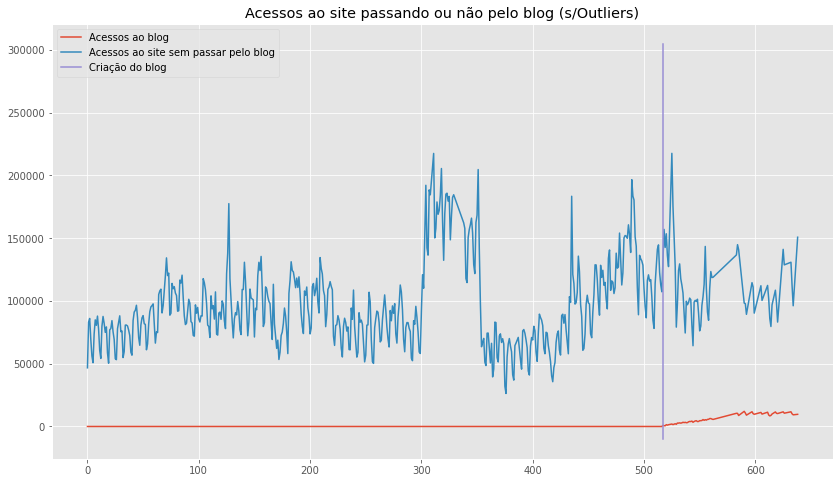

In [29]:
plt.figure(figsize = (14,8))
point1 = [517,-10000]
point2 = [517,305000]
x_values = [point1[0], point2[0]]
y_values = [point1[1], point2[1]]

plt.title('Acessos ao site passando ou não pelo blog (s/Outliers)')
plt.plot(df_wOutliers['usuarios_blog'], label='Acessos ao blog')
plt.plot(df_wOutliers['usuarios_site'], label='Acessos ao site sem passar pelo blog')
plt.plot(x_values, y_values, label='Criação do blog')
plt.legend()

plt.savefig('acessos_comparacao_Outlier.jpg')

Obs: Aqui não retiramos os outliers pois o número de observaçõs nY seria muito pequeno para a convergência da estatística de teste

Obs2: Consideramos nesse teste, o período dos 3 meses anteriores ao lançamento do blog, pois o mês 02/20 apresentou uma considerável queda com relação a todo o período anterior apresentado.

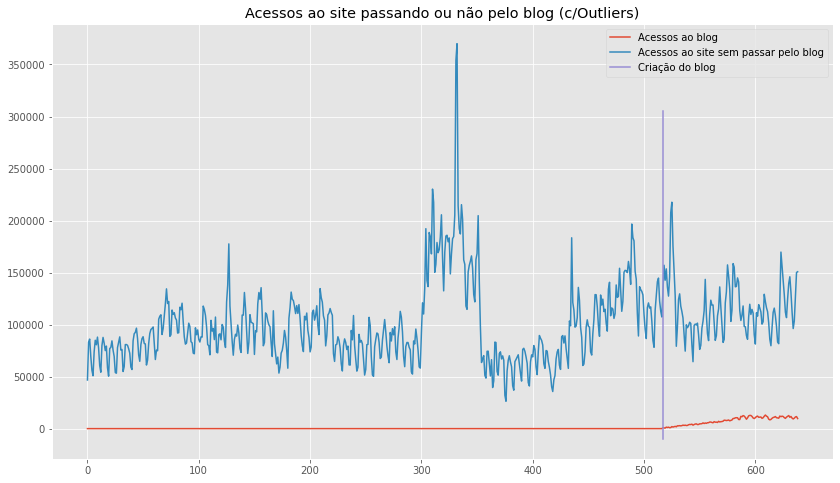

In [30]:
plt.figure(figsize = (14,8))
point1 = [517,-10000]
point2 = [517,305000]
x_values = [point1[0], point2[0]]
y_values = [point1[1], point2[1]]

plt.title('Acessos ao site passando ou não pelo blog (c/Outliers)')
plt.plot(df['usuarios_blog'], label='Acessos ao blog')
plt.plot(df['usuarios_site'], label='Acessos ao site sem passar pelo blog')
plt.plot(x_values, y_values, label='Criação do blog')
plt.legend()

plt.savefig('acessos_comparacao_wOutlier.jpg')

* $X = X_1, X_2, ..., X_{nX}$, são os acessos sem passar pelo blog antes de sua criação
* $Y = Y_1, Y_2, ..., X_{nY}$, são os acessos sem passar pelo blog após a sua criação
* Mesmas suposições do teste anterior

Podemos fazer o seguinte teste de hipótese:

$H_0: \mu_D = 0$ vs $H_1: \mu_D > 0$, considerando que as variâncias são diferentes, sendo $\mu_D = \mu_{antes} - \mu_{depois}$

In [31]:
idx = (df['usuarios_blog'] > 0).idxmax()  #data do evento

X = df.loc[425:idx-1]['usuarios_site']  #dados antes do evento
nX = len(X)
X_barra = np.mean(X)
S_X = np.var(X)

Y = df.loc[idx:]['usuarios_site']  #dados após o evento
nY = len(Y)
Y_barra = np.mean(Y)
S_Y = np.var(Y)

T_obs = (X_barra - Y_barra)/math.sqrt((S_X/ nX) + (S_Y/nY))
numerador = ((S_X/nX) + (S_Y/nY))**2
denominador = ((((S_X/nX)**2)/(nX-1)) + (((S_Y/nY)**2)/(nY-1)))
gl = numerador/denominador

alpha = 0.05
t_critico = 1.97287  #quantil 

if T_obs >= t_critico:
  print('Hipótese nula rejeitada: a média após o evento é menor')
elif T_obs <= -t_critico:
   print('Hipótese nula rejeitada: a média após o evento é maior')
else: print('Hipótese nula aceita: a média não se alterou')

Hipótese nula aceita: a média não se alterou


O acesso ao site sem passar pelo blog não se alterou, fazendo todas as considerações acima. Novamente, partindo da informação de que a receita aumentou, a hipótese mais plausível ainda sim é de que novos clientes estão acessando o blog, e posteriormente o site, e que clientes antigos, não foram muito afetados pela criação do blog, uma vez que esses já eram clientes, continuaram comprando na mesma empresa, sem que o blog trouxesse muitas "novidades"

De qualquer forma, mais uma vez, **a influência do blog para a empresa é positiva**